In [1]:
#Importing the necessary modulues beforehand is a good practice
import os
import torch
import pandas as pd
import numpy as np
import math
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
#Classes of the dataset should be defined explicitly
labels_str={
0:"Hit",
1:"Kick",
2:"Punch",
3:"Push",
4:"ridehorse",
5:"shootgun",
6:"stand",
7:"wave"}

## Preparing the Data

In [3]:
DATA_DIR = "../input/fight-dataset/actions (2)/actions" #root directory comtaning the dataset.

TRAIN_DIR = DATA_DIR + '/train'                           # Sub-directory containing training images
TEST_DIR = DATA_DIR + '/test'                             # Sub-directory containing test images

In [4]:
#Initializing the values needed.
batch_size = 64 
stats = ([0.485, 0.456, 0.406] #mean value of each channel in imagenet dataset.
         , [0.229, 0.224, 0.225]) #standard deviation value of each channel in imagenet dataset.
image_size=224 #size of the image required. 

In [5]:
#ImageFolder is very useful for image datasets as it takes the labels from the folder names and sends the images accordingly to the model.
train_ds = ImageFolder(TRAIN_DIR, transform=T.Compose([
    T.Resize((image_size,image_size)), #getting all the iamges of unique size as the images in the dataset may be of different sizes.
    T.ToTensor(), #converts the arrays to tensor.
    T.Normalize(*stats)])) #Normalizing the data which will be very useful for early convergence during training.
#val denotes validation set.Here we will use our test data as validation data.
val_ds = ImageFolder(TEST_DIR, transform=T.Compose([
    T.Resize((image_size,image_size)),
    T.ToTensor(),
    T.Normalize(*stats)])) #'*' will make the tuple values according to arguements.

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) #The last two parameters are used to optimize the loading of the data to the gpu.
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [6]:
#The below function is used to renormalize the image for visualization of the dataset.
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0] 
#The below 2 functions are used for visualizing the images in grid form.
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

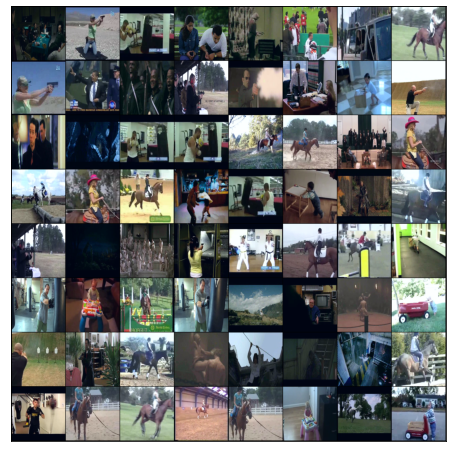

In [7]:
show_batch(train_dl)

## Model - Transfer Learning

In [8]:
#FBeta Score is an evaluation metric used for complex datasets which is used to determine the performance of the model.
def F_score(output, label, threshold=0.5, beta=1):
    prob = torch.argmax(torch.exp(output)/sum(torch.exp(output)),axis=-1).view(1,-1) #don't forget about axis and view.

    TP = (prob & label).sum(1).float() #True Positive -> Total number of True predictions that are actually True.
    TN = ((~prob) & (~label)).sum(1).float() #True Negative -> Total number of False predictions that are actually False.
    FP = (prob & (~label)).sum(1).float() #False Positive -> Total number of False prdictions that are actually True.
    FN = ((~prob) & label).sum(1).float() #False Negative -> Total number of True predictions that are actually False

    precision = torch.mean(TP / (TP + FP + 1e-12)) #Predictions that are True among the Total Predicted True values.
    recall = torch.mean(TP / (TP + FN + 1e-12)) #Predictions that are True among the Total actual True values.
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [9]:
#This class is used for training and validation purposes which i have explained in my previous posts. For clarification you can refer there which I will linking down.
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets= batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

[Learn about ResNets.](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)

Check out torchvision models: https://pytorch.org/docs/stable/torchvision/models.html

In [10]:
#There are more State-of-the-Art pre-trained models which are mostly trained on ImageNet dataset. ResNet is one of them.
resnet34 = models.resnet34(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [11]:
class ActionResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Using a pretrained model
        self.network = models.resnet34(pretrained=True) #pretrained states that the model is taken with trained weights.
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 256)
        #Adding top layers for better performance.
        self.network1=nn.Linear(256,8)
        self.networkact=nn.ReLU()
        self.softmax=nn.Softmax(dim=1)
    
    def forward(self, xb):
        out=self.network(xb)
        out=self.networkact(out)
        out=self.network1(out)
        return self.softmax(out) #for matrices dimension is 1 as we say to model to do softmax to the last dimension(i.e vectors)
    #the below function will make only the top layers to be available for training i.e the layers we added.
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    #the below function will make the entire model trainable.
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Training

In [15]:
@torch.no_grad() #Not to perform any backprop calculation during this cell is running.
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
#the below function is used to get the learning_rate from the optimizer.
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
#Fit function for one-cyclical-learningrate-scheduler.
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0.1, grad_clip=True, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() #To clear unwanted training data from memory
    history = []
    
    # Set up custom optimizer with weight decay where weight decay is a type of regularization technique which is used to reduce overfitting.
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay) 
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping which is used to prevent exploding gradients i.e gradient values which will go very high.
            #Here gradient values will be cutted off to a value when it goes beyond that value i.e if value>1,then value=1.
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
#Fit function for Learning_rate_finder
def fit(epochs, start_lr,end_lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    lrs=[]
    
    # LR function lambda

    lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (epochs * len( train_dl))) 

    optimizer = opt_func(model.parameters(), start_lr )
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            #Updating gradients
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
        #logging lr at each epoch end.
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = [lr_step]
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
model = to_device(ActionResNet(), device) 

In [18]:
model.unfreeze() #unfreezing to get the optimal learning rate.

In [19]:
#Initializing the required values for learning_rate_finder.
epochs = 4
start_lr = 1e-7
end_lr = 0.1
opt_func = torch.optim.Adam

In [20]:
%%time
history = fit(epochs, start_lr,end_lr, model, train_dl, val_dl, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0000, train_loss: 2.0027, val_loss: 1.8413, val_score: 0.7005



Epoch [1], last_lr: 0.0001, train_loss: 1.4261, val_loss: 1.5549, val_score: 0.7781



Epoch [2], last_lr: 0.0032, train_loss: 1.5235, val_loss: 1.9412, val_score: 0.7441



Epoch [3], last_lr: 0.1000, train_loss: 2.0162, val_loss: 2.1010, val_score: 0.7674
CPU times: user 5min 26s, sys: 1min 58s, total: 7min 24s
Wall time: 27min 26s


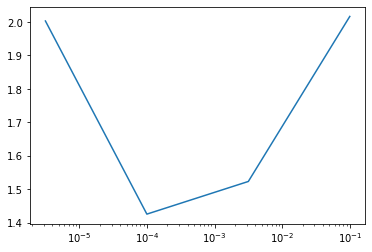

In [21]:
#Plotting Learning_rate vs Training_Loss
import matplotlib.pyplot as plt
plt.semilogx([x.get('lrs') for x in history],[x.get('train_loss') for x in history])

In [22]:
model = to_device(ActionResNet(), device) #Re-initializing the model to start training.

First, freeze the ResNet layers and train some epochs. This only trains the final layer to start classifying the images.

In [23]:
model.freeze()

In [24]:
#Initializing the required values.
epochs = 4
max_lr = 8e-5
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [25]:
%%time 
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0001, train_loss: 1.5038, val_loss: 1.5383, val_score: 0.8073



Epoch [1], last_lr: 0.0001, train_loss: 1.2936, val_loss: 1.5104, val_score: 0.8175



Epoch [2], last_lr: 0.0000, train_loss: 1.2815, val_loss: 1.5195, val_score: 0.8161



Epoch [3], last_lr: 0.0000, train_loss: 1.2786, val_loss: 1.5271, val_score: 0.8054
CPU times: user 5min 44s, sys: 1min 53s, total: 7min 37s
Wall time: 27min 25s


In [26]:
#type(model)
import torch
torch.save(model.state_dict(), '../working/sequence.pth')
#model.save('sequence.h5')

Now, unfreeze and train some more.

In [27]:
model.unfreeze()

In [28]:
#Now let's evaluate the model to get final results on the performance.
print([evaluate(model, val_dl)])

[{'val_loss': 1.5270609855651855, 'val_score': 0.8054454326629639}]


In [29]:
#Let's now plot the validation F-beta scores.
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

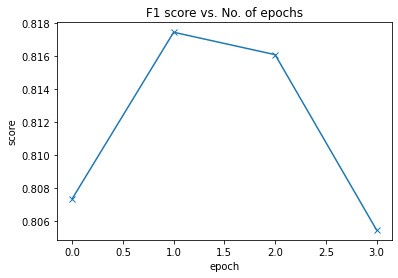

In [30]:
plot_scores(history)

In [31]:
#Here we plot train_loss and val_loss to check for overfitting.
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

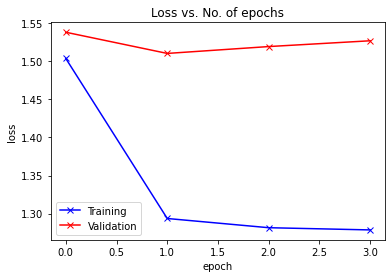

In [32]:
plot_losses(history)

In [33]:
#This graph shows how learning rate values went through the training.
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

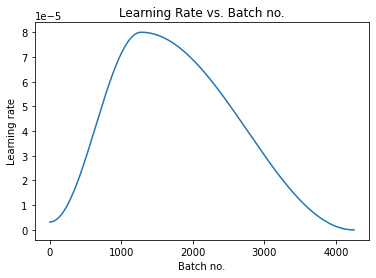

In [34]:
plot_lrs(history)

## Making predictions and submission

In [35]:
def predict_single(image,label):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)  #to load the image to the gpu memory.
    preds = model(xb)
    prediction = preds[0]
    print("Actual Label: ",labels_str[label])
    print("Prediction: ", labels_str[torch.argmax(prediction).tolist()]) #The predicted class is extracted from the predicted values.
    show_images(image)

**Let us now predict using the model to see the performance.**

Actual Label:  wave
Prediction:  wave


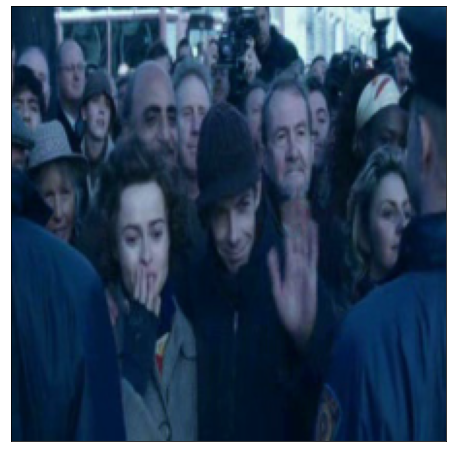

In [36]:
predict_single(*val_ds[6200])

In [37]:
emotion_dict= {0:'Angry',5:'Neutral', 4:'Neutral',1:'Neutral',6:'Surprise',2:'Neutral',3:'Happy'}